In [1]:
import datasets
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet, words
from nltk.stem import WordNetLemmatizer
import nltk

lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')
en_stopwords = set(stopwords.words('english'))

# data = datasets.load_dataset("wikipedia", "20220301.en")
data = datasets.load_dataset("bookcorpus/bookcorpus")

/Users/Yourui/Documents/bloom-filters/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Yourui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Yourui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Generating train split: 100%|██████████| 74004228/74004228 [06:37<00:00, 186183.46 examples/s]


In [29]:
import string

def tokenize(sentence):
    tokenized = word_tokenize(sentence.translate(str.maketrans('', '', string.punctuation)))
    return [lemmatizer.lemmatize(token) for token in tokenized if token not in en_stopwords and wordnet.synsets(token)]

In [30]:
tokenize(sent_tokenize(next(iter(data['train']))['text'].lower())[0])

['usually', 'tearing', 'around', 'living', 'room', 'playing', 'toy']

In [31]:
import contextlib
import numpy as np

def generate_frequencies(word, n_occurrences=10000, deltas=None):
    if deltas is None:
        deltas = [-4, -3, -2, -1, 1, 2, 3, 4]
    word = lemmatizer.lemmatize(word)

    frequencies = {}
    occurrences = 0

    for i, row in enumerate(data['train']):
        sentences = sent_tokenize(row['text'].lower())

        for sentence in sentences:
            tokenized = tokenize(sentence)
            if word in tokenized:
                indices = [i for i, x in enumerate(tokenized) if x == word]
                for index in indices:
                    for delta in deltas:
                        with contextlib.suppress(IndexError):
                            try:
                                frequencies[tokenized[index + delta]] += 1
                            except KeyError:
                                frequencies[tokenized[index + delta]] = 1

                occurrences += 1
                if occurrences >= n_occurrences:
                    return frequencies

        if i % 1000 == 0:
            print(f'"{word}", {i}th row processed, {occurrences}/{n_occurrences} occurrences')

In [32]:
# keep only the most frequently occurring words next to the target word (ex: 1000+ occurrences) + aggregate those words + collect data
    # Table 1: Most frequent words
    # Table 2: Most frequent words with count vectors
# test discarding bits with high variance values

In [33]:
import json

def store_encoding(word, fname, args):
    frequencies = generate_frequencies(word, **args)
    
    with open(fname, 'r') as f:
        encodings = json.load(f)
    encodings[word] = frequencies
    with open(fname, 'w') as f:
        json.dump(encodings, f, indent=4)

In [34]:
l = ["man","woman","king","queen"]

for value in l:
    store_encoding(value, 'frequencies.json', {'n_occurrences':50000, 'deltas': [-2, -1, 1, 2]})

"man", 0th row processed, 0/50000 occurrences
"man", 1000th row processed, 23/50000 occurrences
"man", 2000th row processed, 42/50000 occurrences
"man", 3000th row processed, 59/50000 occurrences
"man", 4000th row processed, 65/50000 occurrences
"man", 5000th row processed, 77/50000 occurrences
"man", 6000th row processed, 86/50000 occurrences
"man", 7000th row processed, 93/50000 occurrences
"man", 8000th row processed, 102/50000 occurrences
"man", 9000th row processed, 110/50000 occurrences
"man", 10000th row processed, 128/50000 occurrences
"man", 11000th row processed, 134/50000 occurrences
"man", 12000th row processed, 139/50000 occurrences
"man", 13000th row processed, 142/50000 occurrences
"man", 14000th row processed, 143/50000 occurrences
"man", 15000th row processed, 147/50000 occurrences
"man", 16000th row processed, 149/50000 occurrences
"man", 17000th row processed, 152/50000 occurrences
"man", 18000th row processed, 157/50000 occurrences
"man", 19000th row processed, 166/

In [8]:
with open('frequencies.json', 'r') as f:
    frequencies = json.load(f)

In [87]:
top_1000_freq = {
    key: dict(
        sorted(
            frequencies[key].items(), key=lambda item: item[1], reverse=True
        )[:1000]
    )
    for key in frequencies.keys()
}
with open('top_frequencies.json', 'w') as f:
    json.dump(top_1000_freq, f, indent=4)

In [117]:
import mmh3
from bitarray import bitarray

def hash_token(token, bits):
    bit_array = bitarray(bits)
    bit_array.setall(0)
    
    for i in range(3):
        digest = mmh3.hash(token, i) % bits
        bit_array[digest] = True
    return bit_array

In [131]:
representations = {}
for key in top_100_freq.keys():
    w_representation = np.zeros(32, dtype=int)
    representations[key] = {'indv':{}, 'total':None}
    for word in top_100_freq[key].keys():
        representations[key]['indv'][word] = list(hash_token(word, 32))
        w_representation += np.array(list(hash_token(word, 32)))
    representations[key]['total'] = w_representation.tolist()

In [132]:
with open('representations.json', 'w') as f:
    json.dump(representations, f, indent=4)

In [133]:
arr = []
for representation in representations.values():
    arr += representation['total']
representation_16_array = np.array(arr).reshape((4,-1))

In [134]:
representation_16_array

array([[ 5, 12, 15, 13,  7,  7,  5, 13,  7, 14, 12,  9,  7,  7,  9,  6,
         6, 11,  8, 10, 12,  8,  8, 12,  9,  7, 14,  4,  8, 10,  8, 11],
       [13,  9,  7, 11, 10, 12,  3,  8,  9, 14, 11, 10,  6, 11,  9,  9,
         8,  7,  8, 12, 12,  9, 15,  7,  7,  7, 13,  8,  4,  8,  6,  8],
       [10,  8, 10, 18,  9,  8,  9,  7,  8, 13,  7,  5, 11,  6,  7,  8,
         6,  8,  9,  6, 11, 10, 14, 16,  5,  8,  7, 10,  7,  6, 12,  9],
       [ 6,  6, 11, 15, 10, 13,  8,  8,  7, 13,  6,  8, 11,  7,  8,  9,
         7,  8,  8, 11,  9, 12,  9, 13,  8,  6,  8,  7,  9,  8,  9,  7]])

([<matplotlib.axis.YTick at 0x32476b3e0>,
 [Text(0, 0, 'man'),
  Text(0, 1, 'woman'),
  Text(0, 2, 'king'),
  Text(0, 3, 'queen')])

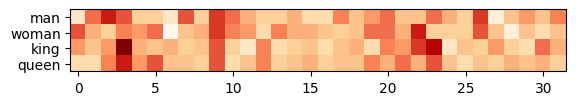

In [135]:
import matplotlib.pyplot as plt
plt.imshow(representation_16_array, cmap='OrRd')
plt.yticks(ticks=np.arange(4), labels=representations.keys())

In [136]:
kqmw = representation_16_array[2] - representation_16_array[0] + representation_16_array[1]

In [137]:
from scipy import spatial
print(
    spatial.distance.cosine(kqmw, representation_16_array[3]),
    spatial.distance.cosine(kqmw, representation_16_array[2]),
    spatial.distance.cosine(representation_16_array[0], representation_16_array[1])
)

0.10101374192201851 0.06302968059092962 0.06636776495626895


In [ ]:
# another approach for calculating similarity – the sum of the product of the frequencies of common shared words?

In [16]:
def similarity(w1, w2):
    return sum(w1[word]/f * w2[word]/f for word in w1.keys() if word in w2.keys())

In [17]:
similarity(frequencies['man'], frequencies['woman'])

0.00082959953125

In [18]:
similarity(frequencies['queen'], frequencies['woman'])

0.0005302209375

In [19]:
similarity(frequencies['man'], frequencies['queen'])

0.0004516371875

In [25]:
def addition(w1, w2, multipliers=(1,1)):
    return {
        word: max(multipliers[0] * w1.get(word, 0) + multipliers[1] * w2.get(word, 0), 0)
        for word in list(w1.keys()) + list(w2.keys())
    }

In [26]:
similarity(addition(frequencies['woman'], addition(frequencies['king'], frequencies['man'], (1,-1))), frequencies['queen'])

0.0013693040625

In [27]:
addition(frequencies['woman'], addition(frequencies['king'], frequencies['man'], (1,-1)))

{'imposing': 1,
 'authority': 74,
 'largely': 23,
 'marriage': 150,
 'order': 99,
 'limited': 30,
 'sexual': 207,
 'freedom': 40,
 'right': 895,
 'autonomy': 9,
 'gay': 27,
 'queer': 5,
 'autism': 1,
 'may': 219,
 'girl': 213,
 'due': 37,
 'awareness': 11,
 'particularly': 69,
 'though': 64,
 'unidentified': 6,
 'system': 39,
 'expanded': 13,
 'african': 103,
 'american': 795,
 'elected': 181,
 'local': 64,
 'peddler': 1,
 'selling': 11,
 'clothes': 20,
 'jewellery': 9,
 'alarm': 2,
 'sounded': 2,
 'identity': 20,
 'away': 16,
 'fled': 23,
 'panic': 1,
 'agamemnon': 18,
 'taken': 39,
 'named': 176,
 'slave': 81,
 'men': 2363,
 'sex': 141,
 'ruthlessly': 1,
 'slaying': 2,
 'child': 773,
 'element': 8,
 'view': 61,
 'aristotle': 5,
 'analysis': 6,
 'equal': 92,
 'weight': 9,
 'happiness': 6,
 'need': 45,
 'well': 149,
 'witnessed': 5,
 'proving': 2,
 'charm': 1,
 'overcome': 5,
 'attractive': 30,
 'partner': 34,
 'found': 120,
 'find': 45,
 'presence': 15,
 'le': 75,
 'value': 19,
 'woma